# jl_dmba_ppp_project_v6




- Use standardised dataset prep process (feature_update.ipynb)
    - need to select desired variables to create finalised dataset (saved as './resources/datasets/ppp_updated_transformed_v4.csv')
- Rerun Decision tree model on dataset
    - Look at performance

## Prep - importing libraries, reading csv etc

### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import random

# Import library to use Decision Trees
from sklearn.tree import DecisionTreeClassifier
# Import library to split data into training and test sets
from sklearn.model_selection import train_test_split
# Import library to measure performance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import statistics as stat
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import LabelEncoder


### Reading CSV

In [3]:
#read csv
df = pd.read_csv('../resources/datasets/ppp_updated_transformed_FINAL.csv')
df.head()

isFraud  log_InitialApprovalAmount_standardised  \
0        1                                0.985015   
1        1                                0.928765   
2        1                                0.421815   
3        1                                0.019799   
4        1                               -0.125152   

   log_CurrentApprovalAmount_standardised  log_TOTAL_PROCEED_standardised  \
0                                0.995606                        0.995611   
1                                0.938581                        0.938587   
2                                0.424650                        0.424659   
3                                0.017099                        0.017109   
4                               -0.129848                       -0.129838   

   log_PROCEED_Per_Job_standardised  log_JobsReported_standardised  \
0                          0.255028                       0.715986   
1                         -0.036805                       0.904422   
2                          1.176095                      -0.533077   
3                          0.494347                      -0.331917   
4                          0.518176                      -0.479404   

   payroll_over_other  Term_cat_between_24_60  Term_cat_is_24  Term_cat_is_60  \
0            0.335918                   False            True           False   
1            0.335918                   False            True           False   
2            0.335918                   False            True           False   
3            0.335918                   False            True           False   
4            0.335918                   False            True           False   

   ...  BorrowerState_VI  BorrowerState_VT  BorrowerState_WA  \
0  ...             False             False             False   
1  ...             False             False             False   
2  ...             False             False             False   
3  ...             False             False             False   
4  ...             False             False             False   

   BorrowerState_WI  BorrowerState_WV  BorrowerState_WY  IsFranchise_0  \
0             False             False             False           True   
1             False             False             False           True   
2             False             False             False           True   
3             False             False             False           True   
4             False             False             False           True   

   IsFranchise_1  isAfterBiden_0  isAfterBiden_1  
0          False            True           False  
1          False            True           False  
2          False            True           False  
3          False            True           False  
4          False            True           False  

[5 rows x 156 columns]

In [17]:
df.columns

Index(['isFraud', 'log_InitialApprovalAmount_standardised',
       'log_CurrentApprovalAmount_standardised',
       'log_TOTAL_PROCEED_standardised', 'log_PROCEED_Per_Job_standardised',
       'log_JobsReported_standardised', 'payroll_over_other',
       'Term_cat_between_24_60', 'Term_cat_is_24', 'Term_cat_is_60',
       ...
       'BorrowerState_VI', 'BorrowerState_VT', 'BorrowerState_WA',
       'BorrowerState_WI', 'BorrowerState_WV', 'BorrowerState_WY',
       'IsFranchise_0', 'IsFranchise_1', 'isAfterBiden_0', 'isAfterBiden_1'],
      dtype='object', length=156)

### Performance Report Function

In [4]:
#Performance Report
def generateClassificationReport(y_test,y_pred):
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))    
    print('accuracy is ',accuracy_score(y_test,y_pred))

In [13]:
# Split the data into training, validation and test sets
X = df.drop(columns=['isFraud'])
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y,  random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test,  random_state = 1)

# Decision Tree Classification (dt1)

In [14]:
# Decision Tree 1
dt1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, random_state = 1)
# Give training set for the DT1 to learn from
dt1.fit(X_train, y_train)

# Give the test set to the DT1, which returns its predicted answers
y_pred = dt1.predict(X_val)
dt1_result=[]
generateClassificationReport(y_val,y_pred)
dt1_result.append(accuracy_score(y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192274
           1       0.55      0.40      0.47       104

    accuracy                           1.00    192378
   macro avg       0.78      0.70      0.73    192378
weighted avg       1.00      1.00      1.00    192378

[[192240     34]
 [    62     42]]
accuracy is  0.9995009824408196


#### Hyperparameter Tuning for dt1 (dt1_hyper)

In [19]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score

def objective(trial):
    # Define hyperparameter search space
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    class_weight = trial.suggest_float("class_weight", 0.0, 1.0)


    # Initialize and train Decision Tree Classifier
    dt_model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight={0: class_weight, 1: 1.0 - class_weight},
        random_state=1
    )
    dt_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = dt_model.predict(X_val)

    # Calculate recall
    recall = recall_score(y_val, y_pred)

    return -recall  # Negative because Optuna aims to minimize the objective

# Assuming you have X_train, y_train, X_val, and y_val defined
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params

[I 2023-11-04 16:38:10,446] A new study created in memory with name: no-name-2df739a5-93f7-4e14-ad4b-09d9f8504752
[I 2023-11-04 16:38:16,025] Trial 0 finished with value: -0.019230769230769232 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 6, 'class_weight': 0.6892778064662068}. Best is trial 0 with value: -0.019230769230769232.
[I 2023-11-04 16:38:22,493] Trial 1 finished with value: -0.038461538461538464 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'class_weight': 0.9397674614310617}. Best is trial 1 with value: -0.038461538461538464.
[I 2023-11-04 16:38:33,527] Trial 2 finished with value: -0.6826923076923077 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'class_weight': 0.13172963629001944}. Best is trial 2 with value: -0.6826923076923077.
[I 2023-11-04 16:38:40,944] Trial 3 finished with value: -0.038461538461538464 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_sa

In [8]:
print(best_params)

#{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 16}. Best is trial 2 with value: -0.7692307692307693.
# {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'class_weight': 0.0014891067438111466}. Best is trial 95 with value: -0.9326923076923077.

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 16}


#### Decision tree with best parameters (dt1_hyper)

In [23]:
# Build a Decision Tree model,
best_class_weight=0.0014891067438111466
dt1_hyper = DecisionTreeClassifier( criterion = 'entropy', max_depth= 3, min_samples_split= 2,class_weight= {0: best_class_weight, 1: 1.0 - best_class_weight},random_state = 1)
# Give training set for the DT1_hyper to learn from
dt1_hyper.fit(X_train, y_train)

# Give the test set to the DT1_hyper, which returns its predicted answers
y_pred = dt1_hyper.predict(X_test)
dt1_hyper_result=[]
generateClassificationReport(y_test,y_pred)
dt1_hyper_result.append(accuracy_score(y_test,y_pred))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98    192274
           1       0.01      0.98      0.02       105

    accuracy                           0.96    192379
   macro avg       0.51      0.97      0.50    192379
weighted avg       1.00      0.96      0.98    192379

[[183877   8397]
 [     2    103]]
accuracy is  0.9563413886131023


### OPTUNA W F1 SCORE AS FOCUS

In [36]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def objective(trial):
    # Define hyperparameters to search
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    class_weight = trial.suggest_float("class_weight", 0.0, 1.0)


    # Initialize and train Decision Tree Classifier
    dt_f1hyper_model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight={0: class_weight, 1: 1.0 - class_weight},
        random_state=1
    )

    dt_f1hyper_model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = dt_f1hyper_model.predict(X_val)

    # Calculate F1-score
    f1 = f1_score(y_val, y_pred)

    return f1


# Assuming you have X_train, y_train, X_val, and y_val defined
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params

#F1: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 0.7878241251631138, 'class_weight': 0.9913481291003405}. Best is trial 10 with value: 0.0.



[I 2023-11-04 18:37:56,949] A new study created in memory with name: no-name-368d4040-8946-4618-a429-68467931cc89
[I 2023-11-04 18:38:03,714] Trial 0 finished with value: 0.03773584905660378 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 0.8192497460222495, 'class_weight': 0.5316613730148336}. Best is trial 0 with value: 0.03773584905660378.
[I 2023-11-04 18:38:07,974] Trial 1 finished with value: 0.03773584905660378 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 0.9823139391280712, 'class_weight': 0.6698377274147932}. Best is trial 0 with value: 0.03773584905660378.
[I 2023-11-04 18:38:19,593] Trial 2 finished with value: 0.03773584905660378 and parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 0.11195946312274967, 'class_weight': 0.27852094307893716}. Best is trial 0 with value: 0.03773584905660378.
[I 2023-11-04 18:38:27,465] Trial 3 finished with value: 0.26141732283464564 and parameters: {'criterion':

### Decision Tree with F1 hyperparameter optuna 

In [38]:
# Build a Decision Tree model,
best_class_weight=0.9913481291003405
dt1_hyper = DecisionTreeClassifier( criterion = 'entropy', max_depth= 8, min_samples_split= 0.7878241251631138,class_weight= {0: best_class_weight, 1: 1.0 - best_class_weight},random_state = 1)
# Give training set for the DT1_hyper to learn from
dt1_hyper.fit(X_train, y_train)

# Give the test set to the DT1_hyper, which returns its predicted answers
y_pred = dt1_hyper.predict(X_test)
dt1_hyper_result=[]
generateClassificationReport(y_test,y_pred)
dt1_hyper_result.append(accuracy_score(y_test,y_pred))

#F1: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 0.7878241251631138, 'class_weight': 0.9913481291003405}. Best is trial 10 with value: 0.0.

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192274
           1       0.00      0.00      0.00       105

    accuracy                           1.00    192379
   macro avg       0.50      0.50      0.50    192379
weighted avg       1.00      1.00      1.00    192379

[[192274      0]
 [   105      0]]
accuracy is  0.9994542023817569


### RESULTS FOR DECISION TREE 

- Decision Tree ![without hyperparameter tuning](resource/dt1.png)


- Decision Tree with hyperparameter tuning 


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'class_weight': 0.0014891067438111466}


![with OPTUNA -classweight](resource/dt1_hyper1.png)



- with OPTUNA hyperparameter tuning  {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 16}

![with OPTUNA ](resource/dt1_hyper.png)

# SMOTE 


In [15]:
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
smote = SMOTE()

#Apply Over Sampling
print('Before Oversampling')
print(sorted(Counter(y_train).items()))
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)
print('After Oversampling')
print(sorted(Counter(y_train_smote).items()))

#Fitting Model
dt_smote = DecisionTreeClassifier( criterion = 'gini', max_depth= 4, min_samples_split= 16 ,random_state = 1)
# Give training set for the DT_smote to learn from
dt_smote.fit(X_train_smote, y_train_smote)
smote_dt_result=[]
target_pred = dt_smote.predict(X_val)
generateClassificationReport(y_val,target_pred)
smote_dt_result.append(accuracy_score(y_val,target_pred))


Before Oversampling
[(0, 576821), (1, 314)]
After Oversampling
[(0, 576821), (1, 576821)]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    192274
           1       0.02      0.95      0.03       104

    accuracy                           0.97    192378
   macro avg       0.51      0.96      0.51    192378
weighted avg       1.00      0.97      0.99    192378

[[186818   5456]
 [     5     99]]
accuracy is  0.9716131782220421


### Hyperparameter Tuning for smote_dt (smote_dt_hyper) 

In [24]:
def objective(trial):
    # Define hyperparameter search space
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    class_weight = trial.suggest_float("class_weight", 0.0, 1.0)


    # Initialize and train Decision Tree Classifier
    smote_dt_hyper = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight={0: class_weight, 1: 1.0 - class_weight},
        random_state=1
    )
    smote_dt_hyper.fit(X_train, y_train)

    # Predict on validation set
    y_pred = smote_dt_hyper.predict(X_val)

    # Calculate recall
    recall = recall_score(y_val, y_pred)

    return -recall  # Negative because Optuna aims to minimize the objective

# Assuming you have X_train, y_train, X_val, and y_val defined
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params

[I 2023-11-04 17:02:17,038] A new study created in memory with name: no-name-8c265d21-7d68-4fd4-b01f-24d4f7aa0bcd
[I 2023-11-04 17:02:27,702] Trial 0 finished with value: -0.057692307692307696 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 15, 'class_weight': 0.7788426065040677}. Best is trial 0 with value: -0.057692307692307696.
[I 2023-11-04 17:02:37,767] Trial 1 finished with value: -0.7596153846153846 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'class_weight': 0.06843815086984495}. Best is trial 1 with value: -0.7596153846153846.
[I 2023-11-04 17:02:47,718] Trial 2 finished with value: -0.75 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 13, 'class_weight': 0.15054323079358012}. Best is trial 1 with value: -0.7596153846153846.
[I 2023-11-04 17:02:56,314] Trial 3 finished with value: -0.75 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 10, 'class_weight': 0.

In [ ]:
print(best_params)

#{'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 7}. Best is trial 6 with value: -0.7692307692307693.
# {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'class_weight': 0.0015433883620540323}. Best is trial 12 with value: -0.9326923076923077.

#### SMOTE Decision tree with best parameters (dt1_hyper)

In [27]:
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
smote = SMOTE()

#Apply Over Sampling
print('Before Oversampling')
print(sorted(Counter(y_train).items()))
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)
print('After Oversampling')
print(sorted(Counter(y_train_smote).items()))

#Fitting Model

# Build a Decision Tree model,
best_class_weight=0.0015433883620540323

smote_dt_hyper = DecisionTreeClassifier(criterion= 'entropy', max_depth= 3, min_samples_split= 20,class_weight= {0: best_class_weight, 1: 1.0 - best_class_weight},random_state = 1)
# Give training set for the smote_dt_hyper to learn from
smote_dt_hyper.fit(X_train_smote, y_train_smote)
smote_dt_hyper_result=[]
target_pred = smote_dt_hyper.predict(X_test)
generateClassificationReport(y_test,target_pred)
smote_dt_hyper_result.append(accuracy_score(y_test,target_pred))


Before Oversampling
[(0, 576821), (1, 314)]
After Oversampling
[(0, 576821), (1, 576821)]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    192274
           1       0.00      1.00      0.00       105

    accuracy                           0.00    192379
   macro avg       0.50      0.50      0.00    192379
weighted avg       1.00      0.00      0.00    192379

[[   232 192042]
 [     0    105]]
accuracy is  0.0017517504509327942


## OPTUNA W F1 SCORE AS FOCUS

In [ ]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def objective(trial):
    # Define hyperparameters to search
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)

    # Create and train the model
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_valid)

    # Calculate F1-score
    f1 = f1_score(y_valid, y_pred)

    return f1

# Split your data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and optimize the study
study = optuna.create_study(direction='maximize')  # Optimize for higher F1-score
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params

### RESULTS FOR DECISION TREE WITH SMOTE
- Decision Tree with SMOTE results 
![Decision Tree with SMOTE results](resource/smote_dt.png)


- Decision Tree with SMOTE results & hyperparameter tuning

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'class_weight': 0.0015433883620540323}


![Decision Tree with SMOTE results & hyperparameter tuning](resource/smote_dt_hyper1_t.png)


- Decision Tree with SMOTE results & hyperparameter tuning 
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 7}


![Decision Tree with SMOTE results & hyperparameter tuning](resource/smote_dt_hyper.png)


# SMOTEENN

In [39]:
from imblearn.combine import SMOTEENN
from sklearn.datasets import make_classification


# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=2)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())

# Create and train the decision tree model
smoteenn_dt = DecisionTreeClassifier( criterion = 'gini', max_depth= 4, min_samples_split= 16 ,random_state = 1)
smoteenn_dt.fit(X_resampled, y_resampled)
smoteenn_dt_result=[]
target_pred = smoteenn_dt.predict(X_val)
generateClassificationReport(y_val,target_pred)
smoteenn_dt_result.append(accuracy_score(y_val,target_pred))

Class distribution after resampling:
isFraud
1    576821
0    575504
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    192274
           1       0.02      0.95      0.03       104

    accuracy                           0.97    192378
   macro avg       0.51      0.96      0.51    192378
weighted avg       1.00      0.97      0.99    192378

[[186817   5457]
 [     5     99]]
accuracy is  0.9716079801224672


### Hyperparameter Tuning for smoteenn_dt (smoteenn_dt_hyper)

In [ ]:
def objective(trial):
    # Define hyperparameter search space
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    class_weight = trial.suggest_float("class_weight", 0.0, 1.0)


    # Initialize and train Decision Tree Classifier
    smoteenn_dt= DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight={0: class_weight, 1: 1.0 - class_weight},
        random_state=1
    )
    smoteenn_dt.fit(X_train, y_train)

    # Predict on validation set
    y_pred = smoteenn_dt.predict(X_val)

    # Calculate recall
    recall = recall_score(y_val, y_pred)

    return -recall  # Negative because Optuna aims to minimize the objective

# Assuming you have X_train, y_train, X_val, and y_val defined
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params

# undersampling 

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler


# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling to the training data
X_resampled1, y_resampled1 = rus.fit_resample(X_train, y_train)
rus_dt = DecisionTreeClassifier(criterion = 'gini', max_depth= 4, min_samples_split= 16 ,random_state = 1)
rus_dt_result=[]
rus_dt.fit(X_resampled1, y_resampled1)
target_pred = rus_dt.predict(X_val)
generateClassificationReport(y_val,target_pred)
rus_dt_result.append(accuracy_score(y_val,target_pred))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98    192274
           1       0.01      0.93      0.03       104

    accuracy                           0.96    192378
   macro avg       0.51      0.95      0.50    192378
weighted avg       1.00      0.96      0.98    192378

[[185158   7116]
 [     7     97]]
accuracy is  0.962973936728732


### RUS Decision tree with Hyperparameter Tuning (rus_dt_hyper)

In [32]:
def objective(trial):
    # Define hyperparameter search space
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    class_weight = trial.suggest_float("class_weight", 0.0, 1.0)


    # Initialize and train Decision Tree Classifier
    rus_dt= DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight={0: class_weight, 1: 1.0 - class_weight},
        random_state=1
    )
    rus_dt.fit(X_train, y_train)

    # Predict on validation set
    y_pred = rus_dt.predict(X_val)

    # Calculate recall
    recall = recall_score(y_val, y_pred)

    return -recall  # Negative because Optuna aims to minimize the objective

# Assuming you have X_train, y_train, X_val, and y_val defined
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params

[I 2023-11-04 17:48:46,137] A new study created in memory with name: no-name-119dcd4f-fc2b-400b-a92f-ef2e154ce85e
[I 2023-11-04 17:48:59,099] Trial 0 finished with value: -0.14423076923076922 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 15, 'class_weight': 0.7419172772517282}. Best is trial 0 with value: -0.14423076923076922.
[I 2023-11-04 17:49:08,783] Trial 1 finished with value: -0.057692307692307696 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 13, 'class_weight': 0.716553902454916}. Best is trial 0 with value: -0.14423076923076922.
[I 2023-11-04 17:49:16,480] Trial 2 finished with value: -0.7692307692307693 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 10, 'class_weight': 0.1105140861717897}. Best is trial 2 with value: -0.7692307692307693.
[I 2023-11-04 17:49:21,763] Trial 3 finished with value: -0.7692307692307693 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_spl

In [33]:
print(best_params)

#{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 15, 'class_weight': 0.0010189603966910266}. Best is trial 13 with value: -0.9230769230769231.

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 15, 'class_weight': 0.0010189603966910266}


### RUS Decision tree with best parameters (rus_dt_hyper)

In [34]:
# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

#Apply Over Sampling
print('Before Oversampling')
print(sorted(Counter(y_train).items()))
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print('After Oversampling')
print(sorted(Counter(y_train_rus).items()))

#Apply Over Sampling

# Build a Decision Tree model,
best_class_weight=0.0010189603966910266

rus_dt_hyper = DecisionTreeClassifier(criterion= 'entropy', max_depth= 3, min_samples_split= 20,class_weight= {0: best_class_weight, 1: 1.0 - best_class_weight},random_state = 1)
# Give training set for the smote_dt_hyper to learn from
rus_dt_hyper.fit(X_train_rus, y_train_rus)
rus_dt_hyper_result=[]
target_pred = rus_dt_hyper.predict(X_test)
generateClassificationReport(y_test,target_pred)
rus_dt_hyper_result.append(accuracy_score(y_test,target_pred))

Before Oversampling
[(0, 576821), (1, 314)]
After Oversampling
[(0, 314), (1, 314)]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    192274
           1       0.00      1.00      0.00       105

    accuracy                           0.00    192379
   macro avg       0.50      0.50      0.00    192379
weighted avg       1.00      0.00      0.00    192379

[[   248 192026]
 [     0    105]]
accuracy is  0.0018349196118079415


#### Results For Decision Tree with RUS undersampling 

- Decision Tree with RUS results 
![Decision Tree with RUS results](resource/rus_dt.png)

- Decision Tree with RUS results & hyperparameter tuning 

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 15, 'class_weight': 0.0010189603966910266}


![Decision Tree with RUS results & hyperparameter tuning](resource/rus_dt_hype.png)


# SHAP FEATURE ANALYSIS

In [ ]:
#!pip install shap

### SHAP

100%|===================| 2305402/2307284 [01:17<00:00]        

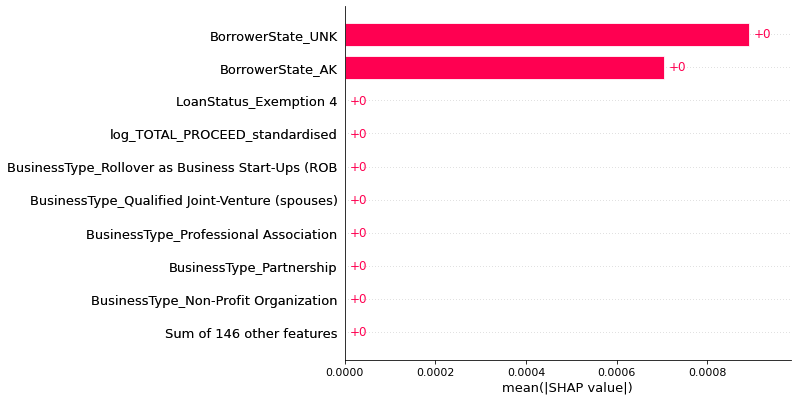

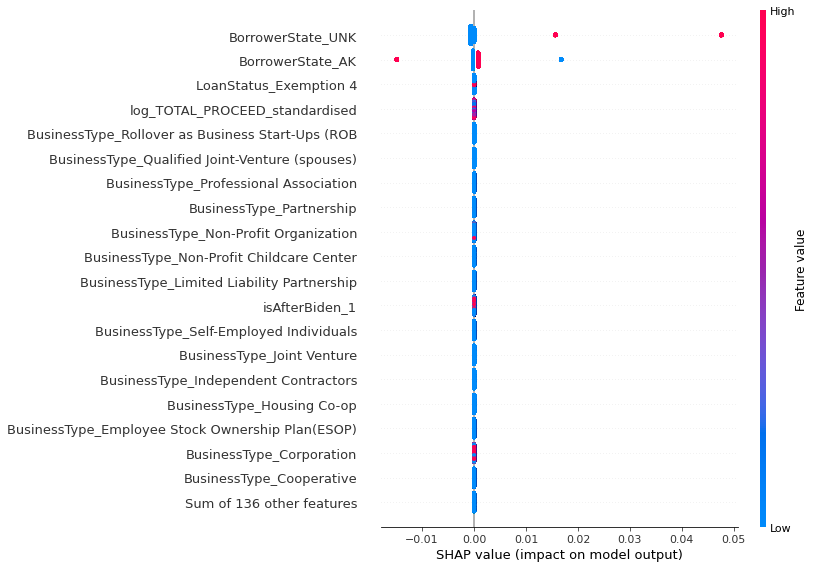

In [40]:
import shap
shap.initjs()

# Assuming 'model' is your trained decision tree model and 'X_train' is your training data
x_sample = X_train_smote.astype('float')
explainer_dt = shap.Explainer(dt1_hyper, x_sample)
shap_values_dt = explainer_dt(x_sample)

shap.plots.bar(shap_values_dt[:, :, 1])
shap.plots.beeswarm(shap_values_dt[:, :, 1], max_display=20)

### SHAP for dt1_hyper (Decision Tree with Hyperparameter Tuning)
![Decision Tree with Hyperparameter Tuning](resource/shap_dt1_hyper.png)

In [ ]:
import shap
shap.initjs()

# Assuming 'model' is your trained decision tree model and 'X_train' is your training data
x_sample = X_train_smote.astype('float')
explainer_dt = shap.Explainer(dt_smote, x_sample)
shap_values_dt = explainer_dt(x_sample)

shap.plots.bar(shap_values_dt[:, :, 1])
shap.plots.beeswarm(shap_values_dt[:, :, 1], max_display=20)

### SHAP for dt1_hyper (Decision Tree withSMOTE)
![Decision Tree with SMOTE](resource/shap_dt_smote.png)

# Decision Tree Diagram

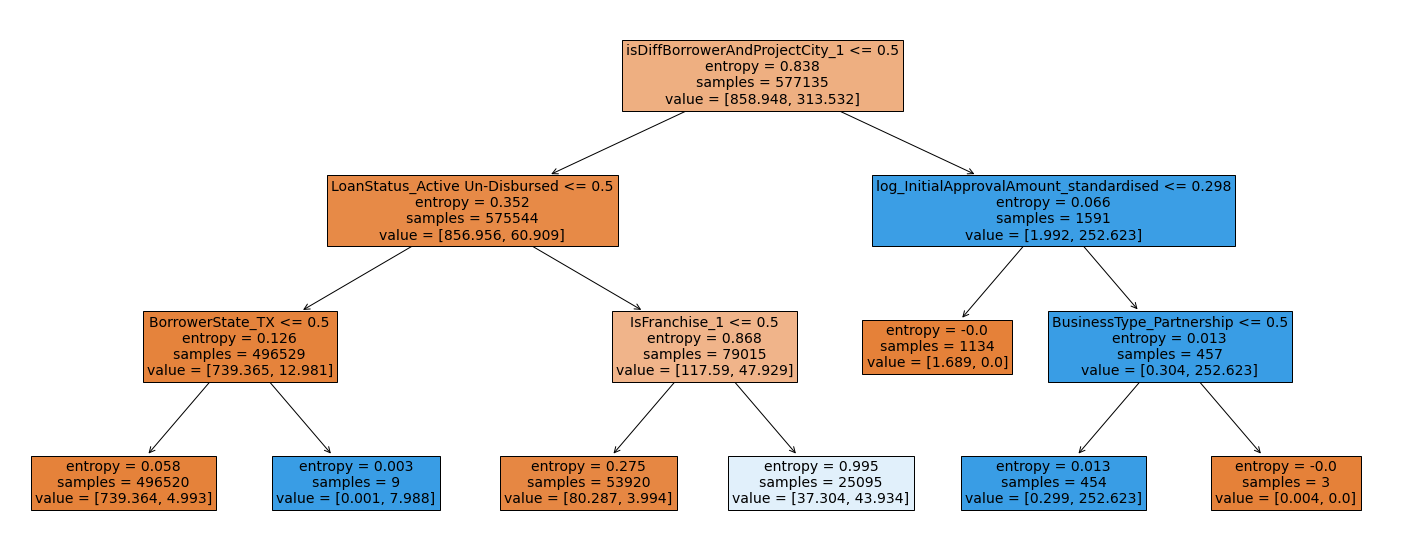

array([0, 1])

In [31]:
# Import libraries to show DT as a plot
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

# Generate a plot showing the DT
plt.figure(figsize=(25,10))
plot_tree(dt1_hyper.fit(X_train,y_train), feature_names = df.columns, filled = True, fontsize = 14)
plt.show()


# Show all class names
dt1_hyper.classes_


#### Decision Tree Diagram 

![decision tree](resource/dtdiagram_dt1_hyper.png)


### Confusion Matrix

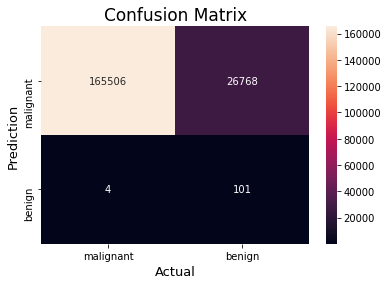

Accuracy   : 0.8608372015656595
Precision : 0.0037589787487439055
Recall    : 0.9619047619047619
F1-score  : 0.007488692815303626


In [36]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# compute the confusion matrix
cm = confusion_matrix(y_test,target_pred )
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['malignant', 'benign'],
            yticklabels=['malignant', 'benign'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
 
 
# Finding precision and recall
accuracy = accuracy_score(y_test, target_pred )
print("Accuracy   :", accuracy)
precision = precision_score(y_test, target_pred )
print("Precision :", precision)
recall = recall_score(y_test, target_pred )
print("Recall    :", recall)
F1_score = f1_score(y_test, target_pred )
print("F1-score  :", F1_score)

#### Confusion Matrix


![confusion matrix](resource/cfmatrix.png)


In [1]:
import pickle

# Assuming 'dt' is your trained decision tree model

# Save the model to a file
with open('dt1_model.pkl', 'wb') as model_file:
    pickle.dump(dt1, model_file)

# Save the model to a file
with open('dt_smote_model.pkl', 'wb') as model_file:
    pickle.dump(dt_smote, model_file)

   
# Save the model to a file
with open('smote_dt_hyper_model.pkl', 'wb') as model_file:
    pickle.dump(smote_dt_hyper, model_file)

    
# Save the model to a file
with open('rus_dt_model.pkl', 'wb') as model_file:
    pickle.dump(rus_dt, model_file)

    
# Save the model to a file
with open('rus_dt_hyper_model.pkl', 'wb') as model_file:
    pickle.dump(rus_dt_hyper, model_file)

NameError: name 'dt1' is not defined